# Fourier filter vs explicit form for time series

If the data is indeed periodic, then Fourier extrapolation and filtering approaches work the same but if it is not, then Fourier filter seems to do better for some reason.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fourier extrapolation as a prediction tool

https://www.kdnuggets.com/2016/11/combining-different-methods-create-advanced-time-series-prediction.html

In [2]:
def fourierExtrapolation(x, n_predict=12, n_harmonics=12):
    # x = input series
    # n_predict = number of time snapshots for prediction
    # n_harmonics = number of fourier frequencies to keep
    n = x.size
    x_f = np.fft.fft(x)
    f = np.fft.fftfreq(n)
    #idx = np.arange(n)
    #idx.sort(lambda i: np.abs(f[i]))
    idx = np.argsort(np.abs(f))
    t_arr = np.arange(0, n + n_predict)
    forecast = np.zeros(t_arr.size)
    
    for j in idx[:1 + 2*n_harmonics]:
        ampl  = np.abs(x_f[j])/n # amplitude
        phase = np.angle(x_f[j]) # phase
        forecast += ampl * np.cos(2*np.pi*f[j]*t_arr + phase)
        
    return forecast

## Dummy data


`endpoint=False` (in `np.linspace`) is necessary for Fourier extrapolation to work well since periodic data means that the last point equals the first.

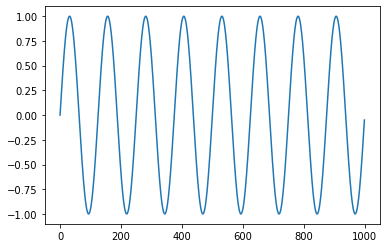

In [3]:
# 2 full sinusoid wavelengths with an array of 1000 points
n_wavelengths = 8
t_length = 1000
dummy_series = np.sin(2*np.pi * np.linspace(0,
                                            n_wavelengths,
                                            t_length,
                                            endpoint=False)
                     )
plt.plot(dummy_series)

## TEST 

If the function is written correctly, it should correctly predict the sine series

**NOTE**: If the `n_wavelengths=2`, the fourier Extrapolation will be terrible as I think the fft picks up noise.

## Method 1: Fourier extrapolation above

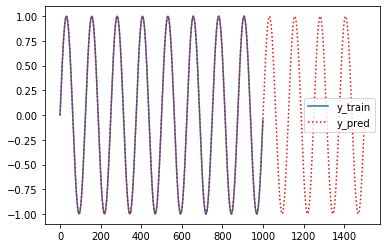

In [4]:
# For n_wavelengths = 2
# 500 points = 1 wavelength
# Prediction for the next 500 points should yield a perfect full wavelength
y_pred = fourierExtrapolation(dummy_series, 
                              n_predict=500, 
                              n_harmonics=n_wavelengths)
plt.plot(dummy_series, label='y_train')
plt.plot(y_pred, 'r:', label='y_pred')
plt.legend()

(1000,)


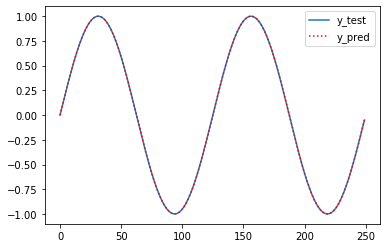

In [5]:
# Less number of points should yield an incomplete wave

y_train = dummy_series[:-250]
y_test  = dummy_series[-250:]

y_pred = fourierExtrapolation(y_train, 
                              n_predict=250, 
                              n_harmonics=n_wavelengths)

print(y_pred.shape)

plt.plot(y_test, label='y_test')
plt.plot(y_pred[-250:], 'r:', label='y_pred')
plt.legend()

## Method 2: Fourier filtering

Amplitude returned is **divided by 2** for real signals. Basically need to add both the positive and negative frequencies, which for a real signal are equal. See the answer here:

https://www.mathworks.com/matlabcentral/answers/84141-why-fft-function-returns-amplitude-divided-by-2

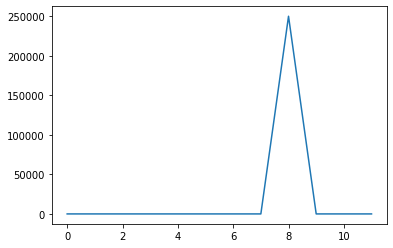

In [6]:
x_f = np.fft.fft(dummy_series)
plt.plot(np.abs(x_f)[:12]**2)

In [7]:
print(np.abs(x_f[n_wavelengths-1:n_wavelengths+1])**2)
print(np.abs(x_f[-n_wavelengths:-n_wavelengths+2])**2)

[3.61923446e-27 2.50000000e+05]
[2.50000000e+05 3.61923446e-27]


## Apply the filter

Note above that most frequencies are practically zero, and only one positive and one negative frequency is contributing.

In [8]:
dum_f = np.zeros_like(x_f)

dum_f[n_wavelengths] = 2*x_f[n_wavelengths]

# Should be (otherwise multiply by 2)
#dum_f[16] = x_f[16] + x_f[-16]

x_f_f = np.fft.ifft(dum_f)

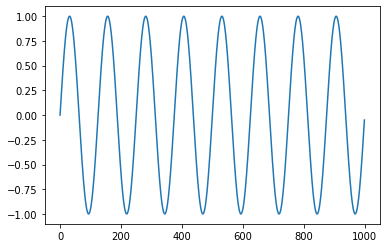

In [9]:
plt.plot(x_f_f.real)

## METRICS

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error

In [11]:
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-6): 
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps ))) * 100 

In [12]:
# SMAPE is typically defined such that its maximum value
# (for y_pred = 0) will be 200% 
# I have removed the factor 2 to reduce it to [0,100] range
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

In [13]:
def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [14]:
# Method 1:
y_pred1 = y_pred[-250:]

# Method 2:
y_pred2 = x_f_f[-250:].real

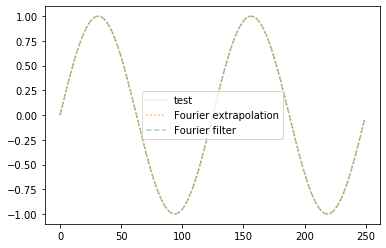

In [15]:
plt.plot(y_test, label='test', alpha=0.1)
plt.plot(y_pred1, ':', label='Fourier extrapolation', alpha=0.6)
plt.plot(y_pred2, '--', label='Fourier filter', alpha=0.4)
plt.legend()

### Extrapolation error

In [16]:
print_scores(y_test, y_pred1)

R2 score: 1.0
MSE score: 4.435398874016358e-30
MAE score: 1.6051575661686681e-15
Median AE score: 1.3322676295501878e-15
MAPE score: 1.4019891996809759e-09
SMAPE score: 1.4013706975523177e-07


### Filtering error

In [17]:
print_scores(y_test, y_pred2)

R2 score: 1.0
MSE score: 3.1242431649338766e-30
MAE score: 1.34165097170465e-15
Median AE score: 9.992007221626409e-16
MAPE score: 1.0013775623164558e-09
SMAPE score: 1.0007870365775846e-07
